In [1]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable


# Milestone 3: Preprocessing

In the previous milestone, we merged the **TCG** and **Price Guide** datasets. We saved the resulting dataframe as a `.csv` file. For this milestone, we will first begin by normalizing our data and encoding our categorical variables. We will then train and evaluate our first model. Let's begin my importing important libraries. 

### Imports

In [36]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder



### Data Loading

In [4]:
price_guide_tcg = pd.read_csv("price_guide_tcg_cleaned.csv", low_memory=False)
price_guide_tcg.dropna()
price_guide_tcg.describe()

,id,loose-price,graded-price,box-only-price,manual-only-price,bgs-10-price,condition-17-price,condition-18-price,sales-volume,hp
count,3.030000e+04,30132.000000,23242.000000,23345.000000,22502.000000,22504.000000,22653.000000,22507.000000,30300.000000,25631.000000
mean,1.815578e+06,9.113746,40.473400,50.029936,169.867231,260.751890,144.303368,101.864726,48.108482,96.110569
std,1.610918e+06,57.197150,203.630556,280.753070,1698.911993,2705.228337,641.144056,1019.301576,102.838685,52.140362
min,2.522800e+04,0.010000,0.140000,0.990000,0.980000,0.990000,1.000000,1.000000,1.000000,10.000000
25%,8.887088e+05,1.340000,12.060000,13.000000,34.910000,52.000000,44.000000,21.000000,5.000000,60.000000
50%,9.596655e+05,1.990000,16.065000,18.000000,42.720000,65.000000,50.000000,26.000000,12.000000,80.000000
75%,2.254008e+06,4.292500,29.807500,33.000000,90.045000,137.000000,99.990000,54.000000,38.000000,120.000000
max,7.747251e+06,4223.260000,17033.540000,27550.000000,221599.740000,332400.000000,42316.000000,132960.000000,1837.000000,340.000000


In [5]:
price_guide_tcg.columns

Index(['tcg_id', 'id', 'console-name', 'product-name', 'loose-price',
       'graded-price', 'box-only-price', 'manual-only-price', 'bgs-10-price',
       'condition-17-price', 'condition-18-price', 'sales-volume',
       'release-date', 'set', 'series', 'publisher', 'generation',
       'release_date', 'artist', 'name', 'set_num', 'types', 'supertype',
       'subtypes', 'hp', 'weaknesses', 'rarity', 'legalities', 'resistances'],
      dtype='object')

In [6]:
price_guide_tcg['types'].value_counts()

types
['Water']                    3787
['Grass']                    3706
['Psychic']                  3331
['Colorless']                3324
['Fighting']                 2853
['Fire']                     2251
['Lightning']                2177
['Darkness']                 1602
['Metal']                    1275
['Dragon']                    666
['Fairy']                     392
['Grass', 'Darkness']          21
['Fighting', 'Darkness']       19
['Lightning', 'Metal']         18
['Darkness', 'Metal']          15
['Water', 'Darkness']          15
['Fire', 'Metal']              13
['Water', 'Metal']             12
['Psychic', 'Metal']           11
['Fire', 'Darkness']           11
['Lightning', 'Darkness']      10
['Fighting', 'Metal']           8
['Psychic', 'Darkness']         6
['Fire', 'Grass']               6
['Grass', 'Metal']              6
['Fire', 'Water']               4
['Metal', 'Fighting']           2
['Fairy', 'Psychic']            2
['Lightning', 'Grass']          2
['Fairy'

In [7]:
price_guide_tcg['rarity'].value_counts()

rarity
Common                       8768
Uncommon                     8549
Rare                         4782
Rare Holo                    3380
Promo                        1115
Rare Ultra                    776
Rare Holo EX                  335
Rare Secret                   331
Rare Rainbow                  325
Rare Holo V                   280
Rare Holo GX                  172
Rare Shiny                    149
Illustration Rare             123
Rare Holo VMAX                122
Ultra Rare                    102
Double Rare                    96
Rare Holo LV.X                 57
Rare Holo VSTAR                56
Special Illustration Rare      53
Rare Shiny GX                  35
Trainer Gallery Rare Holo      34
Hyper Rare                     29
Radiant Rare                   28
Rare BREAK                     27
Rare Prism Star                27
Rare Holo Star                 26
Rare Prime                     26
Rare Shining                   26
LEGEND                         18
Rare AC

In [8]:
subset_df = price_guide_tcg[['rarity', 'types', 'generation', 'bgs-10-price', 'graded-price', 'hp', 'sales-volume']].copy()
print(subset_df.head())

         rarity          types generation  bgs-10-price  graded-price     hp  \
0      Uncommon            NaN      Sixth           NaN           NaN    NaN   
1      Uncommon            NaN      Sixth           NaN           NaN    NaN   
2      Uncommon            NaN      Sixth           NaN           NaN    NaN   
3      Uncommon            NaN      Sixth          58.0         15.11    NaN   
4  Rare Holo EX  ['Lightning']      Sixth          62.0         28.09  170.0   

   sales-volume  
0           5.0  
1           1.0  
2           1.0  
3           7.0  
4          81.0  


## Categorical Variable Encoding

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Specify thresholds for each column
thresholds = {
    'types': 1000  ,        # Minimum count for 'types'
    'rarity': 1000  ,    # Minimum count for 'rarity'
    'generation':1500
}

# Remove rows with rare categories for each column based on the thresholds
for col, threshold in thresholds.items():
    counts = subset_df[col].value_counts()
    valid_categories = counts[counts >= threshold].index
    subset_df = subset_df[subset_df[col].isin(valid_categories)]

In [10]:
subset_df['types'].value_counts()

types
['Water']        2886
['Grass']        2857
['Psychic']      2525
['Colorless']    2506
['Fighting']     2263
['Fire']         1658
['Lightning']    1590
['Darkness']     1236
['Metal']         966
Name: count, dtype: int64

In [11]:
subset_df['rarity'].value_counts()

rarity
Common       7388
Uncommon     4588
Rare         3985
Rare Holo    2526
Name: count, dtype: int64

In [12]:
subset_df['generation'].value_counts()

generation
Eighth     3482
Seventh    2978
Third      2536
Fourth     2206
Fifth      2049
Sixth      1983
Ninth      1629
Second     1624
Name: count, dtype: int64

In [13]:
subset_df.shape

(18487, 7)

In [14]:
subset_df = subset_df.dropna()

In [15]:
subset_df.shape

(12759, 7)

In [16]:
subset_df.head()

,rarity,types,generation,bgs-10-price,graded-price,hp,sales-volume
9,Uncommon,['Grass'],Sixth,58.0,15.01,70.0,7.0
12,Common,['Psychic'],Sixth,36.0,9.28,60.0,29.0
13,Common,['Psychic'],Sixth,90.0,16.34,60.0,14.0
16,Uncommon,['Grass'],Sixth,58.0,23.00,120.0,24.0
17,Uncommon,['Grass'],Sixth,58.0,15.01,120.0,12.0


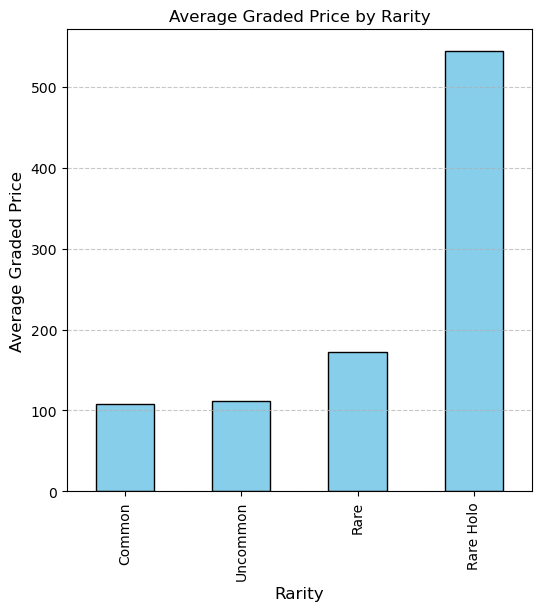

In [17]:
rarity_means = subset_df.groupby('rarity')['bgs-10-price'].mean().sort_values()


plt.figure(figsize=(6, 6))
rarity_means.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Graded Price by Rarity', fontsize=12)
plt.xlabel('Rarity', fontsize=12)
plt.ylabel('Average Graded Price', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [18]:
features = [ 'types', 'generation', 'bgs-10-price', 'graded-price', 'hp', 'sales-volume']
target = 'rarity'

X = subset_df[features]
y = subset_df[target]


In [19]:
X = pd.get_dummies(X, columns=['types', 'generation'], drop_first=True)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [30]:
## Random Forest

In [31]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [32]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [35]:
y_train_pred = model.predict(X_train)

# Classification Report for Training Set
print("=== Training Set Evaluation ===")
print(classification_report(y_train, y_train_pred))

# Confusion Matrix for Training Set
print("Confusion Matrix (Training Set):")
print(confusion_matrix(y_train, y_train_pred))

# Accuracy for Training Set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

=== Training Set Evaluation ===
              precision    recall  f1-score   support

      Common       1.00      1.00      1.00      3773
        Rare       1.00      1.00      1.00      2428
   Rare Holo       1.00      1.00      1.00      1708
    Uncommon       1.00      1.00      1.00      2298

    accuracy                           1.00     10207
   macro avg       1.00      1.00      1.00     10207
weighted avg       1.00      1.00      1.00     10207

Confusion Matrix (Training Set):
[[3772    0    0    1]
 [   0 2428    0    0]
 [   0    0 1708    0]
 [   1    0    1 2296]]
Training Accuracy: 0.9997060840599589


In [33]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


              precision    recall  f1-score   support

      Common       0.83      0.85      0.84       892
        Rare       0.54      0.52      0.53       609
   Rare Holo       0.65      0.63      0.64       470
    Uncommon       0.57      0.58      0.58       581

    accuracy                           0.67      2552
   macro avg       0.65      0.65      0.65      2552
weighted avg       0.67      0.67      0.67      2552

[[758  29  15  90]
 [ 48 316 114 131]
 [ 18 125 298  29]
 [ 93 117  34 337]]
Accuracy: 0.6696708463949843


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [220]:
data = subset_df.copy()


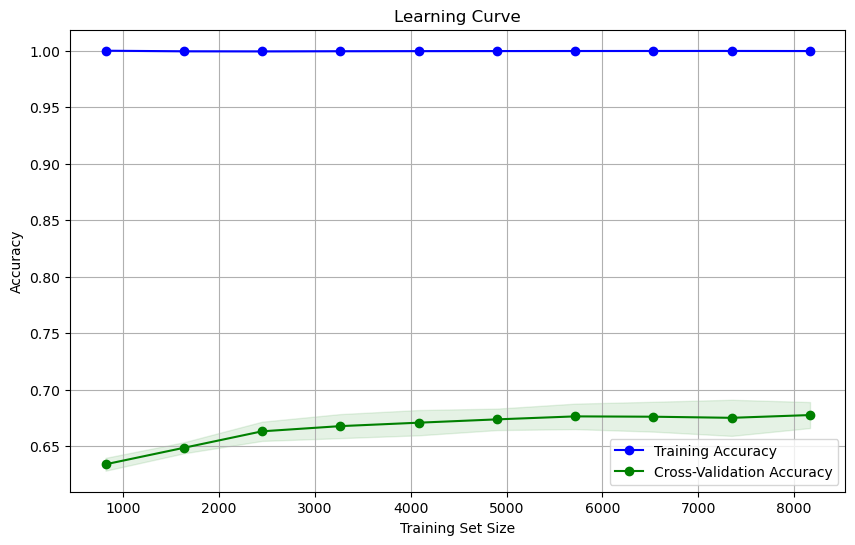

In [37]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()